In [1]:
import torch
import time
from tt_utils import *
from fcn_approx_utils import GMM, BGMM

In [2]:
device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
0.1**(1./10.0)

0.7943282347242815

In [4]:
dim_list = [2,5,10]
mix_list = [5,10,20]
s_list =[0.1,0.25, 0.5, 0.75]

Ndim = len(dim_list)
Nmix = len(mix_list)
Ns = len(s_list)
Nt = 3

tt_data_err = torch.empty((Ndim, Nmix, Ns,Nt))
tt_data_time = torch.empty((Ndim, Nmix, Ns,Nt))
tt_data_rank = torch.empty((Ndim, Nmix, Ns,Nt))

bgmm_data_err = torch.empty((Ndim, Nmix, Ns,Nt))
bgmm_data_time = torch.empty((Ndim, Nmix, Ns,Nt))
L = 1.0

for i, dim_ in enumerate(dim_list):
    for j, nmix_ in enumerate(mix_list):
        for k, s_ in enumerate(s_list):
            for p in range(Nt):
                print("###########")
                print(i,j,k,p)
                print(dim_,nmix_,s_,p)
                print("###########")
                gmm = GMM(n=dim_,nmix=nmix_,L=L,mx_coef=None,mu=None,s=s_, device=device)
                pdf = gmm.pdf
                ndata_train = int(1e5)*dim_
                x_train = 2*L*(-0.5 + torch.rand((ndata_train,dim_)).to(device))
                y_train = pdf(x_train).view(-1,1)
                ndata_test = 10000
                x_test = 2*L*(-0.5 + torch.rand((ndata_test,dim_)).to(device))
                y_test = pdf(x_test)
                x_test_np = x_test.detach().cpu().numpy()
                y_test_np = y_test.detach().cpu().numpy()
                bgmm = BGMM(nmix = 2*nmix_)
                x_train_np = gmm.generate_sample(ndata_train)
                bgmm.load_data(x_train_np)
                t01 = time.time()
                bgmm.fit()
                t02=time.time()
                y_bgmm = bgmm.pdf(x_test_np)
                mse_bgmm =  (((y_bgmm.reshape(-1)-y_test_np.reshape(-1))/(1e-9+np.abs(y_test_np).reshape(-1)))**2).mean()
                 
                dt = t02-t01
                bgmm_data_err[i,j,k,p] = 1*mse_bgmm
                bgmm_data_time[i,j,k,p] = dt
                print("mse_bgmm: ", mse_bgmm)
                
                n_discretization = torch.tensor([200]*dim_).to(device)
                domain = [torch.linspace(-L,L,n_discretization[i_]).to(device) for i_ in range(dim_)] 
                t1 = time.time()
                tt = cross_approximate(fcn=pdf,  max_batch=10**6, domain=domain, 
                                        rmax=200, nswp=20, eps=1e-3, verbose=False, 
                                        kickrank=10, device=device)
                t2 = time.time()

                y_tt =  get_value(tt_model=tt, x=x_test.to(device),  domain=domain, 
                                    n_discretization=n_discretization , max_batch=10**5, device=device)

                mse_tt = (((y_tt.view(-1)-y_test.view(-1))/(1e-9+y_test.view(-1).abs()))**2).mean()
                print("mse_tt: ", mse_tt)
                tt_data_err[i,j,k,p] = 1*mse_tt
                tt_data_rank[i,j,k,p] = max(tt.ranks_tt)
                tt_data_time[i,j,k,p] = (t2-t1)


                torch.save({'dim_list':dim_list,'s_list':s_list,'mix_list':mix_list,
                          'tt_data_err':tt_data_err,
                         'tt_data_time':tt_data_time,
                         'tt_data_rank':tt_data_rank},'tt_data_2.pt')
                torch.save({'dim_list':dim_list,'s_list':s_list,'mix_list':mix_list,
                          'bgmm_data_err':bgmm_data_err,
                         'bgmm_data_time':bgmm_data_time},'bgmm_data_2.pt')

###########
0 0 0 0
2 5 0.1 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0245)
mse_tt:  tensor(0.0002)
###########
0 0 0 1
2 5 0.1 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.6577)
mse_tt:  tensor(0.0002)
###########
0 0 0 2
2 5 0.1 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(2410.0391)
mse_tt:  tensor(0.0002)
###########
0 0 1 0
2 5 0.25 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0111)
mse_tt:  tensor(7.6700e-07)
###########
0 0 1 1
2 5 0.25 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0009)
mse_tt:  tensor(2.1644e-07)
###########
0 0 1 2
2 5 0.25 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0024)
mse_tt:  tensor(4.1933e-07)
###########
0 0 2 0
2 5 0.5 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0004)
mse_tt:  tensor(6.6299e-09)
###########
0 0 2 1
2 5 0.5 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0015)
mse_tt:  tensor(8.5902e-09)
###########
0 0 2 2
2 5 0.5 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0003)
mse_tt:  tensor(1.6517e-09)
###########
0 0 3 0
2 5 0.75 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0004)
mse_tt:  tensor(3.1403e-10)
###########
0 0 3 1
2 5 0.75 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0001)
mse_tt:  tensor(2.4430e-10)
###########
0 0 3 2
2 5 0.75 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0002)
mse_tt:  tensor(5.0358e-10)
###########
0 1 0 0
2 10 0.1 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0410)
mse_tt:  tensor(0.0001)
###########
0 1 0 1
2 10 0.1 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.1220)
mse_tt:  tensor(0.0002)
###########
0 1 0 2
2 10 0.1 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0147)
mse_tt:  tensor(0.0001)
###########
0 1 1 0
2 10 0.25 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0123)
mse_tt:  tensor(2.9681e-07)
###########
0 1 1 1
2 10 0.25 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0008)
mse_tt:  tensor(6.3614e-08)
###########
0 1 1 2
2 10 0.25 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0010)
mse_tt:  tensor(1.5281e-07)
###########
0 1 2 0
2 10 0.5 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0005)
mse_tt:  tensor(1.3572e-09)
###########
0 1 2 1
2 10 0.5 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0003)
mse_tt:  tensor(7.5748e-10)
###########
0 1 2 2
2 10 0.5 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0005)
mse_tt:  tensor(7.0841e-10)
###########
0 1 3 0
2 10 0.75 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0002)
mse_tt:  tensor(1.4821e-10)
###########
0 1 3 1
2 10 0.75 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0003)
mse_tt:  tensor(2.2818e-10)
###########
0 1 3 2
2 10 0.75 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0004)
mse_tt:  tensor(2.3204e-10)
###########
0 2 0 0
2 20 0.1 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(2.5565)
mse_tt:  tensor(6.1399e-05)
###########
0 2 0 1
2 20 0.1 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.2031)
mse_tt:  tensor(5.8503e-05)
###########
0 2 0 2
2 20 0.1 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0462)
mse_tt:  tensor(3.0847e-05)
###########
0 2 1 0
2 20 0.25 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0006)
mse_tt:  tensor(2.4395e-08)
###########
0 2 1 1
2 20 0.25 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0007)
mse_tt:  tensor(3.8797e-08)
###########
0 2 1 2
2 20 0.25 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0007)
mse_tt:  tensor(3.7638e-08)
###########
0 2 2 0
2 20 0.5 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0003)
mse_tt:  tensor(3.9455e-10)
###########
0 2 2 1
2 20 0.5 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0004)
mse_tt:  tensor(3.6673e-10)
###########
0 2 2 2
2 20 0.5 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0005)
mse_tt:  tensor(1.3738e-09)
###########
0 2 3 0
2 20 0.75 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0004)
mse_tt:  tensor(1.7598e-10)
###########
0 2 3 1
2 20 0.75 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0004)
mse_tt:  tensor(1.9569e-10)
###########
0 2 3 2
2 20 0.75 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0004)
mse_tt:  tensor(1.3070e-10)
###########
1 0 0 0
5 5 0.1 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0040)
mse_tt:  tensor(6.1356e-05)
###########
1 0 0 1
5 5 0.1 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0033)
mse_tt:  tensor(5.9156e-05)
###########
1 0 0 2
5 5 0.1 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0025)
mse_tt:  tensor(5.8745e-05)
###########
1 0 1 0
5 5 0.25 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0163)
mse_tt:  tensor(5.9547e-06)
###########
1 0 1 1
5 5 0.25 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0162)
mse_tt:  tensor(6.2503e-06)
###########
1 0 1 2
5 5 0.25 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0224)
mse_tt:  tensor(6.4275e-06)
###########
1 0 2 0
5 5 0.5 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0025)
mse_tt:  tensor(3.4065e-08)
###########
1 0 2 1
5 5 0.5 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0027)
mse_tt:  tensor(2.9787e-08)
###########
1 0 2 2
5 5 0.5 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0007)
mse_tt:  tensor(2.6933e-08)
###########
1 0 3 0
5 5 0.75 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0005)
mse_tt:  tensor(9.0710e-10)
###########
1 0 3 1
5 5 0.75 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0003)
mse_tt:  tensor(9.9372e-10)
###########
1 0 3 2
5 5 0.75 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0004)
mse_tt:  tensor(9.6600e-10)
###########
1 1 0 0
5 10 0.1 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0544)
mse_tt:  tensor(0.0001)
###########
1 1 0 1
5 10 0.1 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0080)
mse_tt:  tensor(6.2828e-05)
###########
1 1 0 2
5 10 0.1 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0206)
mse_tt:  tensor(8.8920e-05)
###########
1 1 1 0
5 10 0.25 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0164)
mse_tt:  tensor(5.1096e-06)
###########
1 1 1 1
5 10 0.25 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0174)
mse_tt:  tensor(4.5675e-06)
###########
1 1 1 2
5 10 0.25 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(3.1312)
mse_tt:  tensor(3.8588e-06)
###########
1 1 2 0
5 10 0.5 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0013)
mse_tt:  tensor(6.8285e-09)
###########
1 1 2 1
5 10 0.5 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0017)
mse_tt:  tensor(9.8973e-09)
###########
1 1 2 2
5 10 0.5 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0016)
mse_tt:  tensor(9.2903e-09)
###########
1 1 3 0
5 10 0.75 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0004)
mse_tt:  tensor(9.5552e-10)
###########
1 1 3 1
5 10 0.75 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0004)
mse_tt:  tensor(1.0332e-09)
###########
1 1 3 2
5 10 0.75 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0006)
mse_tt:  tensor(8.5436e-10)
###########
1 2 0 0
5 20 0.1 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0716)
mse_tt:  tensor(0.0002)
###########
1 2 0 1
5 20 0.1 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.4117)
mse_tt:  tensor(0.0001)
###########
1 2 0 2
5 20 0.1 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(170.0826)
mse_tt:  tensor(0.0001)
###########
1 2 1 0
5 20 0.25 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0806)
mse_tt:  tensor(3.1304e-06)
###########
1 2 1 1
5 20 0.25 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0347)
mse_tt:  tensor(2.4609e-06)
###########
1 2 1 2
5 20 0.25 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0101)
mse_tt:  tensor(2.1125e-06)
###########
1 2 2 0
5 20 0.5 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0012)
mse_tt:  tensor(3.8348e-09)
###########
1 2 2 1
5 20 0.5 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0014)
mse_tt:  tensor(5.7346e-09)
###########
1 2 2 2
5 20 0.5 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0015)
mse_tt:  tensor(4.1845e-09)
###########
1 2 3 0
5 20 0.75 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0005)
mse_tt:  tensor(9.0269e-10)
###########
1 2 3 1
5 20 0.75 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0006)
mse_tt:  tensor(8.7617e-10)
###########
1 2 3 2
5 20 0.75 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0006)
mse_tt:  tensor(8.1961e-10)
###########
2 0 0 0
10 5 0.1 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(2.0780e-05)
mse_tt:  tensor(9.0813e-07)
###########
2 0 0 1
10 5 0.1 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(2.5540e-05)
mse_tt:  tensor(9.7862e-05)
###########
2 0 0 2
10 5 0.1 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(2.2620e-05)
mse_tt:  tensor(6.6168e-07)
###########
2 0 1 0
10 5 0.25 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0037)
mse_tt:  tensor(3.4120e-06)
###########
2 0 1 1
10 5 0.25 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0044)
mse_tt:  tensor(2.6480e-06)
###########
2 0 1 2
10 5 0.25 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0023)
mse_tt:  tensor(2.0937e-06)
###########
2 0 2 0
10 5 0.5 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0014)
mse_tt:  tensor(1.1662e-07)
###########
2 0 2 1
10 5 0.5 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0025)
mse_tt:  tensor(1.3321e-07)
###########
2 0 2 2
10 5 0.5 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0017)
mse_tt:  tensor(7.6387e-08)
###########
2 0 3 0
10 5 0.75 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0008)
mse_tt:  tensor(2.3080e-09)
###########
2 0 3 1
10 5 0.75 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0007)
mse_tt:  tensor(2.8521e-09)
###########
2 0 3 2
10 5 0.75 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0006)
mse_tt:  tensor(2.5917e-09)
###########
2 1 0 0
10 10 0.1 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0002)
mse_tt:  tensor(8.3547e-07)
###########
2 1 0 1
10 10 0.1 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(7.8268e-05)
mse_tt:  tensor(1.0738e-06)
###########
2 1 0 2
10 10 0.1 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(2.5734e-07)
mse_tt:  tensor(2.5516e-08)
###########
2 1 1 0
10 10 0.25 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0084)
mse_tt:  tensor(4.3193e-06)
###########
2 1 1 1
10 10 0.25 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0055)
mse_tt:  tensor(4.4869e-06)
###########
2 1 1 2
10 10 0.25 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0046)
mse_tt:  tensor(4.2443e-06)
###########
2 1 2 0
10 10 0.5 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0386)
mse_tt:  tensor(7.1343e-08)
###########
2 1 2 1
10 10 0.5 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0022)
mse_tt:  tensor(5.5921e-08)
###########
2 1 2 2
10 10 0.5 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0506)
mse_tt:  tensor(7.0548e-08)
###########
2 1 3 0
10 10 0.75 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0006)
mse_tt:  tensor(2.5904e-09)
###########
2 1 3 1
10 10 0.75 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0005)
mse_tt:  tensor(2.4234e-09)
###########
2 1 3 2
10 10 0.75 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0011)
mse_tt:  tensor(2.9529e-09)
###########
2 2 0 0
10 20 0.1 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0004)
mse_tt:  tensor(2.5779e-06)
###########
2 2 0 1
10 20 0.1 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0007)
mse_tt:  tensor(2.5085e-06)
###########
2 2 0 2
10 20 0.1 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0001)
mse_tt:  tensor(1.8102e-06)
###########
2 2 1 0
10 20 0.25 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(23203.2820)
mse_tt:  tensor(5.2206e-06)
###########
2 2 1 1
10 20 0.25 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0197)
mse_tt:  tensor(4.6819e-06)
###########
2 2 1 2
10 20 0.25 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0202)
mse_tt:  tensor(5.0775e-06)
###########
2 2 2 0
10 20 0.5 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0031)
mse_tt:  tensor(2.4485e-08)
###########
2 2 2 1
10 20 0.5 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0031)
mse_tt:  tensor(2.4524e-08)
###########
2 2 2 2
10 20 0.5 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0025)
mse_tt:  tensor(2.4727e-08)
###########
2 2 3 0
10 20 0.75 0
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0011)
mse_tt:  tensor(2.7418e-09)
###########
2 2 3 1
10 20 0.75 1
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0014)
mse_tt:  tensor(2.6941e-09)
###########
2 2 3 2
10 20 0.75 2
###########


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


mse_bgmm:  tensor(0.0015)
mse_tt:  tensor(3.0406e-09)


In [5]:
tt_data = torch.load('tt_data_2.pt')
bgmm_data = torch.load('bgmm_data_2.pt')

In [6]:
tt_mean = tt_data['tt_data_err'].mean(dim=(-1,-2))
tt_std = tt_data['tt_data_err'].std(dim=(-1,-2))

bgmm_mean = bgmm_data['bgmm_data_err'].mean(dim=(-1,-2))
bgmm_std = bgmm_data['bgmm_data_err'].std(dim=(-1,-2))

In [7]:
tt_bgmm = (tt_data['tt_data_err']/bgmm_data['bgmm_data_err']).detach().cpu()

In [8]:
y_mean = tt_bgmm.mean(dim=(-1,-2))
y_std = tt_bgmm.std(dim=(-1,-2))

In [9]:
dim_list = tt_data['dim_list']
dim_list

[2, 5, 10]

In [10]:
mix_list = tt_data['mix_list']
mix_list

[5, 10, 20]

In [11]:
s_list = tt_data['s_list']
s_list

[0.1, 0.25, 0.5, 0.75]

In [12]:
y_mean.shape

torch.Size([3, 3])

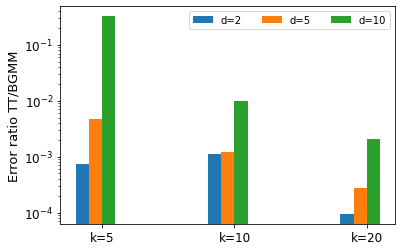

In [13]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 10})

# Define your data
conditions = ['k=5','k=10', 'k=20']
m1_means =  y_mean[0] # Mean values for Method 1
m1_stdevs = y_std[0]   # Standard deviations for Method 1
m2_means = y_mean[1]   # Mean values for Method 2
m2_stdevs =  y_std[1]   # Standard deviations for Method 2
m3_means = y_mean[2]   # Mean values for Method 2
m3_stdevs =  y_std[2]   # Standard deviations for Method 2
# m4_means = y_mean[3]   # Mean values for Method 2
# m4_stdevs = y_std[3]   # Standard deviations for Method 2



# Set the width of the bars
bar_width = 0.1

# Set the positions of the bars on the x-axis
r1 = np.arange(len(conditions))-0.1
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
# r4 = [x + bar_width for x in r3]

# Plot the bars
plt.bar(r1, m1_means,  width=bar_width, label='d=2', capsize=5)
plt.bar(r2, m2_means,  width=bar_width, label='d=5', capsize=5)
plt.bar(r3, m3_means,  width=bar_width, label='d=10', capsize=5)
# plt.bar(r4, m4_means,  width=bar_width, label='d=40', capsize=5)

# Add labels, title, and legend
# plt.xlabel('number of mixture components',fontsize='12')
plt.ylabel('Error ratio TT/BGMM',fontsize='13')
# plt.title('TT vs NN')
plt.xticks([r + bar_width/2 for r in range(len(conditions))], conditions, fontsize=12)
plt.legend(ncol=4)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.savefig('tt_vs_bgmm.jpeg', bbox_inches='tight',pad_inches=0.01, dpi=1000)
# Show the plot
plt.show()
